In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [2]:
# Define paths and parameters
dataset_path = '/kaggle/input/natural-images/natural_images/'
target_size = (128, 128)

# Function to apply Sobel filter
def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)

# Function to load and process images
def load_and_process_images(dataset_path, target_size):
    original_images = []
    sobel_images = []
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                original_images.append(resized_image)
                sobel_images.append(apply_sobel_filter(resized_image))
    return np.array(original_images), np.array(sobel_images)

# Load images
original_images, sobel_images = load_and_process_images(dataset_path, target_size)
# Expand dimensions and normalize
original_images_resized = np.expand_dims(original_images, axis=-1) / 255.0
sobel_images_resized = np.expand_dims(sobel_images, axis=-1) / 255.0

In [3]:
print(original_images_resized.shape,sobel_images_resized.shape)

(6899, 128, 128, 1) (6899, 128, 128, 1)


In [4]:
import numpy as np

# Function to perform rotation by 90, 180, and 270 degrees
def rotate_images(images, sobel_images):
    augmented_images = []
    augmented_sobel_images = []
    
    for image, sobel_image in zip(images, sobel_images):
        # Add original images
        augmented_images.append(image)
        augmented_sobel_images.append(sobel_image)
        
        # Rotate 90 degrees
        rotated_image_90 = np.rot90(image, k=1)
        rotated_sobel_90 = np.rot90(sobel_image, k=1)
        augmented_images.append(rotated_image_90)
        augmented_sobel_images.append(rotated_sobel_90)
        
        # Rotate 180 degrees
        rotated_image_180 = np.rot90(image, k=2)
        rotated_sobel_180 = np.rot90(sobel_image, k=2)
        augmented_images.append(rotated_image_180)
        augmented_sobel_images.append(rotated_sobel_180)
        
        # Rotate 270 degrees
        rotated_image_270 = np.rot90(image, k=3)
        rotated_sobel_270 = np.rot90(sobel_image, k=3)
        augmented_images.append(rotated_image_270)
        augmented_sobel_images.append(rotated_sobel_270)
    
    return np.array(augmented_images), np.array(augmented_sobel_images)

# Apply the rotation-based augmentation
X_augmented, y_augmented = rotate_images(original_images_resized, sobel_images_resized)

# Verify the shapes
print("Augmented Images Shape:", X_augmented.shape)
print("Augmented Sobel Images Shape:", y_augmented.shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the split
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)


Augmented Images Shape: (27596, 128, 128, 1)
Augmented Sobel Images Shape: (27596, 128, 128, 1)
Training Set Shape: (19317, 128, 128, 1)
Validation Set Shape: (4139, 128, 128, 1)
Test Set Shape: (4140, 128, 128, 1)


In [5]:
# Define the Sobel model
def create_sobel_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = (128, 128, 1)
model = create_sobel_model(input_shape)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,161 (2.55 MB)

 Trainable params: 667,009 (2.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/20


I0000 00:00:1725137652.905382     174 service.cc:145] XLA service 0x78f31c0146c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725137652.906132     174 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725137652.906144     174 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1208 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.2477 - mae: 0.3849   

I0000 00:00:1725137661.848254     174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1208/1208 ━━━━━━━━━━━━━━━━━━━━ 73s 50ms/step - loss: 0.0771 - mae: 0.1489 - val_loss: 0.0537 - val_mae: 0.1035 - learning_rate: 0.0010
Epoch 2/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0535 - mae: 0.1014 - val_loss: 0.0530 - val_mae: 0.1053 - learning_rate: 0.0010
Epoch 3/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0515 - mae: 0.0955 - val_loss: 0.0517 - val_mae: 0.0972 - learning_rate: 0.0010
Epoch 4/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0507 - mae: 0.0925 - val_loss: 0.0501 - val_mae: 0.0926 - learning_rate: 0.0010
Epoch 5/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0506 - mae: 0.0904 - val_loss: 0.0496 - val_mae: 0.0926 - learning_rate: 0.0010
Epoch 6/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0500 - mae: 0.0885 - val_loss: 0.0490 - val_mae: 0.0859 - learning_rate: 0.0010
Epoch 7/20
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - loss: 0.0501 - mae: 0.0868 - val_loss: 0.0485 - val_mae: 0.0845 - learning_ra

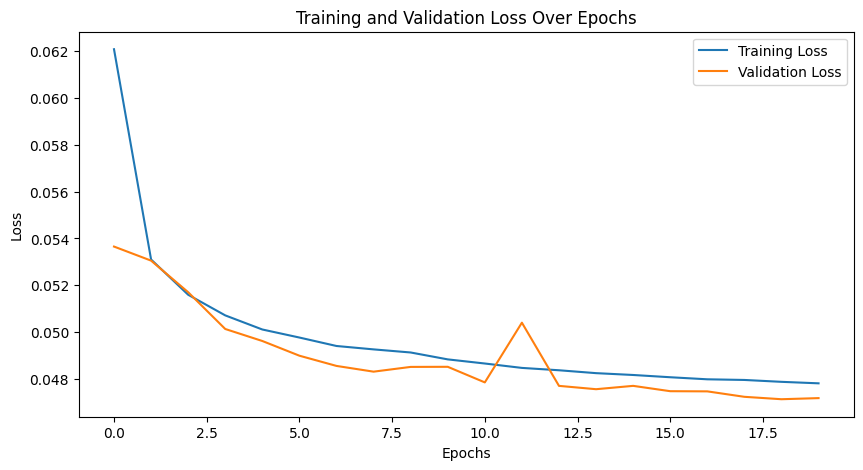

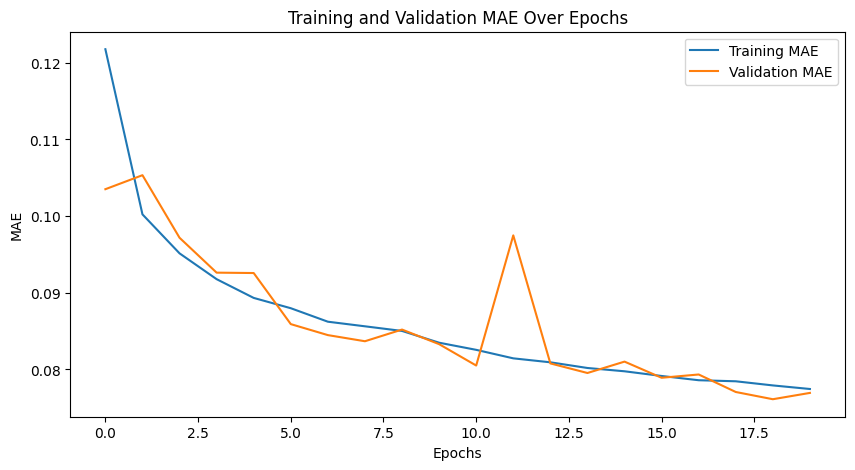

In [6]:
import matplotlib.pyplot as plt

# Define learning rate scheduler and early stopping
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1).numpy()

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=[lr_callback, early_stopping]
)

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting MAE (Mean Absolute Error) over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [7]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate SSIM for a sample image
index = 0
ssim_value = ssim(y_test[index].squeeze(), y_pred[index].squeeze(), data_range=1.0)
print(f"SSIM Value: {ssim_value}")


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0483 - mae: 0.0772
Test Loss: 0.047030068933963776
Test MAE: 0.07590898126363754
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
SSIM Value: 0.7016105698773182


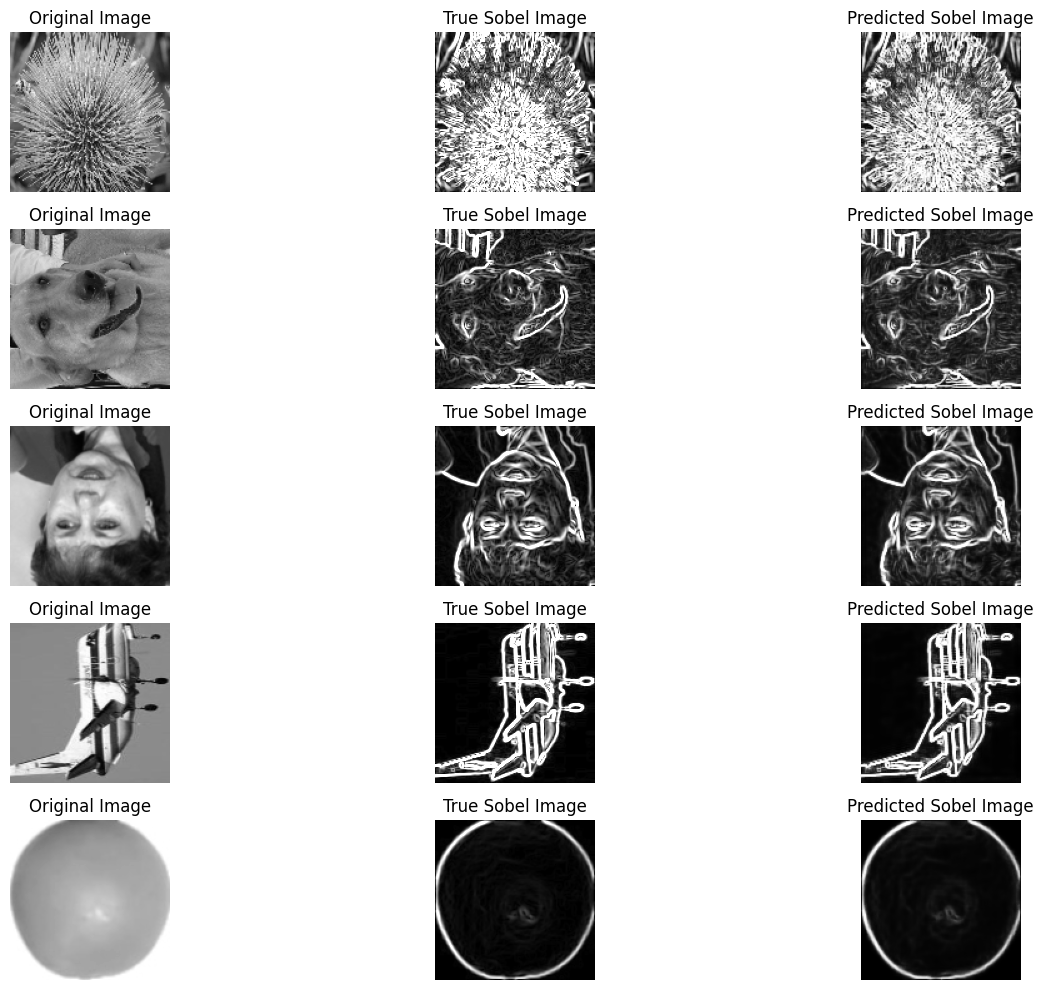

In [8]:
import matplotlib.pyplot as plt

def plot_comparison(original_images, y_true, y_pred, num_images=5):
    """
    Plots original images, true Sobel-filtered images, and predicted Sobel-filtered images side by side.
    
    Args:
    original_images (numpy array): The original images (normalized to [0, 1]).
    y_true (numpy array): The true Sobel-filtered images (normalized to [0, 1]).
    y_pred (numpy array): The predicted Sobel-filtered images (normalized to [0, 1]).
    num_images (int): The number of images to display.
    """
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        # Plot original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title('Original Image')
        plt.axis('off')

        # Plot true Sobel-filtered image
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title('True Sobel Image')
        plt.axis('off')

        # Plot predicted Sobel-filtered image
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title('Predicted Sobel Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot comparison for a few images
plot_comparison(X_test, y_test, y_pred, num_images=5)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,181 (7.64 MB)

 Trainable params: 667,009 (2.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,334,020 (5.09 MB)

In [9]:
import cv2
import numpy as np

# Function to apply Laplacian filter
def apply_laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F, ksize=3)

# Function to apply Prewitt filter
def apply_prewitt_filter(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=int)
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=int)
    prewitt_x = cv2.filter2D(image, -1, kernelx)
    prewitt_y = cv2.filter2D(image, -1, kernely)
    return cv2.magnitude(prewitt_x, prewitt_y)

# Modify load_and_process_images function to include these filters
def load_and_process_images_with_filters(dataset_path, target_size):
    original_images = []
    sobel_images = []
    laplacian_images = []
    prewitt_images = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                resized_image = cv2.resize(image, target_size)
                original_images.append(resized_image)
                sobel_images.append(apply_sobel_filter(resized_image))
                laplacian_images.append(apply_laplacian_filter(resized_image))
                prewitt_images.append(apply_prewitt_filter(resized_image))

    return (np.array(original_images), np.array(sobel_images),
            np.array(laplacian_images), np.array(prewitt_images))


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models

def visualize_feature_maps(model, image):
    # Ensure the model is built
    if not model.built:
        model.build((None,) + model.input_shape[1:])
    
    # Create a model to output the feature maps of each convolutional layer
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    # Get the feature maps for the given image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    activations = activation_model.predict(image)

    # Plot each feature map
    for layer_name, activation in zip([layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)], activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-5
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Example usage for visualization
visualize_feature_maps(model, X_test[0])


ValueError: The layer sequential has never been called and thus has no defined input.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_feature_maps(model, image):
    # Ensure the model is built
    if not model.built:
        model.build((None,) + model.input_shape[1:])

    # Define a function to get feature maps from convolutional layers
    def get_feature_maps(layer_outputs, image):
        # Create a model to extract features
        feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
        return feature_map_model.predict(image[np.newaxis, ...])

    # Collect outputs from convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    
    # Get feature maps for the given image
    activations = get_feature_maps(layer_outputs, image)
    
    # Plot feature maps
    for layer_name, activation in zip([layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)], activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-5
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'Layer: {layer_name}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Example usage for visualization
visualize_feature_maps(model, X_test[0])


ValueError: The layer sequential has never been called and thus has no defined input.

In [ ]:
def create_alternative_filter_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example usage
input_shape = (128, 128, 1)
model_alternative = create_alternative_filter_model(input_shape)

# Train and evaluate the alternative model similarly to the previous models
history_alternative = train_filter_model(model_alternative, X_train_sobel, y_train_sobel, X_val_sobel, y_val_sobel)
evaluate_filter_model(model_alternative, X_test_sobel, y_test_sobel)
